In [1]:
import random
import math
import time
import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms

### 인코더 E를 GAN과 동시에 만드는 방법

In [2]:
# 오차함수 정의
# BCEWithLogitsLoss는 입력에 시그모이드(logit)를 곱한뒤
# 이진 크로스 엔트로피 계산
criterion = nn.BCEWithLogitsLoss(reduction='mean')

# 데이터 로더에서 미니 배치씩 꺼내는 루프

for images in dataloader :
    
    # 미니 배치 크기 1 또는 0의 라벨 역할인 텐서 작성
    # 정답 라벨과 가짜 라벨 작성
    # 에폭의 마지막 반복은 미니 배치 수가 줄어듦
    label_real = torch.full((mini_batch_size,), 1)
    label_fake = torch.full((mini_batch_size,), 0)
    
    # -------------------
    # 1. Discriminator 
    # -------------------
    # 진짜 화상 판정
    z_out_real = E(images)
    d_out_real, _ = D(images, z_out_real)
    
    # 가짜 화상을 생성하여 판정
    input_z = torch.randn(mini_batch_size, z_dim).to(device)
    fake_images = G(input_z)
    d_out_fake, _ = D(fake_images, input_z)
    
    # 오차 계산
    d_loss_real = criterion(d_out_real.view(-1), label_real)
    d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
    d_loss = d_loss_real + d_loss_fake
    
    # 역전파
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    # -------------------
    # 2. Generator 학습 
    # -------------------
    # 가짜 화상을 생성하여 판정
    input_z = torch.randn(mini_batch_size, z_dim).to(device)
    fake_images = G(input_z)
    d_out_fake, _ = D(fake_images, input_z)
    
    # 오차 계산
    g_loss = criterion(d_out_fake.view(-1), label_real)
    
    # 역전파
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()
    
    # -------------------
    # 3. Encoder 학습 
    # -------------------
    # 진짜 화상 z 추정
    z_out_real = E(images)
    d_out_real, _ = D(images, z_out_real)
    
    # 오차 계산
    e_loss = criterion(d_out_real.view(-1), label_fake)
    
    # 역전파
    e_optimizer.zero_grad()
    e_loss.backward()
    e_optimizer.step()

NameError: name 'dataloader' is not defined

---

# Efficient GAN 구현 및 이상 탐지 실시

In [3]:
class Generator(nn.Module) :
    
    def __init__(self, z_dim = 20) :
        super(Generator, self).__init__()
        
        self.layer1 = nn.Sequential(
                        nn.Linear(z_dim, 1024),
                        nn.BatchNorm1d(1024),
                        nn.ReLU(inplace=True))
        
        self.layer2 = nn.Sequential(
                        nn.Linear(1024, 7*7*128),
                        nn.BatchNorm1d(7*7*128),
                        nn.ReLU(inplace=True))
        
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=128, 
                                          out_channels=64,
                                          kernel_size=4, stride=2,
                                          padding=1),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=True))
        
        self.last = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=64,
                                          out_channels=1,
                                          kernel_size=4,
                                          stride=2,
                                          padding=1),
                        nn.Tanh())
        
        # 흑백 화상이므로 출력 채널은 하나
        
    def forward(self, z) :
        out = self.layer1(z)
        out = self.layer2(out)
        
        # 전치 합성곱 층에 넣으므로 텐서형태로 변형
        out = out.view(z.shape[0], 128, 7, 7)
        out = self.layer3(out)
        out = self.last(out)
        
        return out

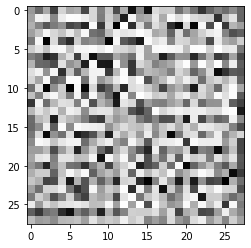

In [5]:
# 동작 확인
import matplotlib.pyplot as plt
%matplotlib inline

G = Generator(z_dim=20)
G.train()

# 입력 난수
# 배치 정규화가 있어 미니 배치 수는 2 이상
input_z = torch.randn(2, 20)

# 가짜 화상 출력
fake_images = G(input_z) # torch.Size([2, 1, 28, 28])
img_transformed = fake_images[0][0].detach().numpy()
plt.imshow(img_transformed, 'gray')
plt.show()

In [8]:
class Discriminator(nn.Module) :
    
    def __init__(self, z_dim=20) :
        super(Discriminator, self).__init__()
        
        # 화상 측 입력 처리
        self.x_layer1 = nn.Sequential(nn.Conv2d(1, 64, 
                                                kernel_size=4,
                                               stride=2,
                                               padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(0.1, inplace=True))
        # 흑백 화상이므로 입력 채널은 하나.
        
        self.x_layer2 = nn.Sequential(nn.Conv2d(64, 64,
                                               kernel_size=4,
                                               stride=2,
                                               padding=1),
                                     nn.BatchNorm2d(64),
                                     nn.LeakyReLU(0.1, inplace=True))
        
        # 난수 측 입력 처리
        self.z_layer1 = nn.Linear(z_dim, 512)
        
        # 최후 판정
        self.last1 = nn.Sequential(nn.Linear(3648, 1024),
                                  nn.LeakyReLU(0.1, inplace=True))
        
        self.last2 = nn.Linear(1024, 1)
        
    def forward(self, x, z) :
        
        # 화상 측 입력 처리
        x_out = self.x_layer1(x)
        x_out = self.x_layer2(x_out)
        
        # 난수 측 입력 처리
        z = z.view(z.shape[0], -1)
        z_out = self.z_layer1(z)
        
        # x_out과 z_out을 결합하여 전결합 층에서 판정
        x_out = x_out.view(-1, 64 * 7 * 7)
        out = torch.cat([x_out, z_out], dim=1)
        out = self.last1(out)
        
        feature = out # 마지막에 채널을 하나로 집약
        feature = feature.view(feature.size()[0], -1) # 2차원으로 변환
        
        out = self.last2(out)
        
        return out, feature


In [9]:
# 동작 확인
D = Discriminator(z_dim=20)
# 가짜 화상 생성
input_z = torch.randn(2, 20)
fake_images = G(input_z)

# 가짜 화상을 D에 입력
d_out, _ = D(fake_images, input_z)

# 출력 d_out에 sigmoid를 곱하여 0 ~ 1로 변환
print(nn.Sigmoid()(d_out))

tensor([[0.5189],
        [0.5179]], grad_fn=<SigmoidBackward>)


## Encoder 구현

In [12]:
class Encoder(nn.Module) :
    
    def __init__(self, z_dim=20) :
        super(Encoder, self).__init__()
        
        self.layer1 = nn.Sequential(
                            nn.Conv2d(1, 32, kernel_size=3,
                                     stride=1),
                            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer2 = nn.Sequential(
                            nn.Conv2d(32, 64, kernel_size=3,
                                     stride=2, padding=1),
                            nn.BatchNorm2d(64),
                            nn.LeakyReLU(0.1, inplace=True))
        
        self.layer3= nn.Sequential(nn.Conv2d(64, 128, kernel_size=3,
                                            stride=2, padding=1),
                                  nn.BatchNorm2d(128),
                                  nn.LeakyReLU(0.1, inplace=True))
        
        # 여기까지 화상 크기는 7x7이 된다
        self.last = nn.Linear(128*7*7, z_dim)
        
    def forward(self, x) :
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # FC에 넣기 위해 텐서 모양으로 변형
        out = out.view(-1, 128*7*7)
        out = self.last(out)
        
        return out

In [13]:
# 동작 확인
E = Encoder(z_dim = 20)

# 입력할 화상 데이터
x = fake_images

# 화상에서 z를 인코드
z = E(x)

print(z.shape)
print(z)

torch.Size([2, 20])
tensor([[-0.5047, -0.3093, -0.0517,  0.3738,  0.2986, -0.0068, -0.0324, -0.0209,
          0.0338,  0.4725,  0.2049, -0.3532,  0.2727, -0.1707, -0.1055, -0.0275,
         -0.0341, -0.1595,  0.1832,  0.1326],
        [-0.4451, -0.0786, -0.2414, -0.0799,  0.3037,  0.2122, -0.1022,  0.4102,
          0.1560,  0.2331,  0.3854, -0.1424,  0.2623,  0.0078,  0.1109,  0.3218,
         -0.0255, -0.0819,  0.2718,  0.0368]], grad_fn=<AddmmBackward>)


In [14]:
# 데이터 로더 구현
# 데이터 로더 준비
def make_datapath_list() :
    '''학습 및 검증 화상 데이터와 어노테이션 데이터의 파일 경로 리스트 작성'''
    
    train_img_list = list() # 화상 파일 경로 저장
    
    for img_idx in range(200) :
        img_path = './pytorch_advanced/gan_anomaly_detection/data/img_78_28size/img_7_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
        img_path = './pytorch_advanced/gan_anomaly_detection/data/img_78_28size/img_8_' + str(img_idx) + '.jpg'
        train_img_list.append(img_path)
        
    return train_img_list

class ImageTransform() :
    '''화상 전처리 클래스'''
    
    def __init__(self, mean, std) :
        self.data_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)])
    def __call__(self, img) :
        return self.data_transform(img)
    
class GAN_Img_Dataset(data.Dataset) :
    '''화상의 데이터셋 클래스, 파이토치의 데이터셋 클래스를 상속'''
    
    def __init__(self, file_list, transform) :
        self.file_list = file_list
        self.transform = transform
        
    def __len__(self) :
        '''화상 매수 반환'''
        return len(self.file_list)
    
    def __getitem__(self, index) :
        '''전처리 화상의 텐서 형식 데이터 취득'''
        
        img_path = self.file_list[index]
        img = Image.open(img_path) # [높이][폭]
        
        # 화상 전처리
        img_transformed = self.transform(img)
        
        return img_transformed
    
    # 데이터 로더 작성과 동작 확인

    
# 파일 리스트 작성
train_img_list = make_datapath_list()

# 데이터셋 작성
mean = (0.5, )
std = (0.5, )

train_dataset = GAN_Img_Dataset(file_list=train_img_list,
                               transform=ImageTransform(mean, std))

# 데이터 로더 작성
batch_size=  64

train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True)
# 동작 확인
batch_iterator = iter(train_dataloader) # 반복자로 변환
images = next(batch_iterator) # 첫 번째 요소를 꺼냄
print(images.size()) # torch.Size([64, 1, 64, 64])

torch.Size([64, 1, 28, 28])


# Efficient GAN 학습

In [29]:
# 모델을 학습시키는 함수 작성
def train_model(G, D, E, dataloader, num_epochs) :
    
    # GPU 사용 가능 여부 확인
    device= torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print('사용 장치:', device)
    
    # 최적화 기법 설정
    lr_ge = 0.0001
    lr_d = 0.0001 / 4
    beta1, beta2 = 0.5, 0.999
    
    g_optimizer = torch.optim.Adam(G.parameters(), lr_ge, [beta1, beta2])
    e_optimizer = torch.optim.Adam(E.parameters(), lr_ge, [beta1, beta2])
    d_optimizer = torch.optim.Adam(D.parameters(), lr_d, [beta1, beta2])
    
    # 오차함수 정의
    # BCEWithLogitsLoss는 입력에 sigmoid(logit)을 곱한 뒤
    # 이진 크로스 엔트로피 계산
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
    
    # 파라미터 하드 코딩
    z_dim = 20
    mini_batch_size = 64
    
    # 네트워크를 GPU로
    G.to(device)
    E.to(device)
    D.to(device)
    
    G.train()
    E.train()
    D.train()
    
    # 네트워크가 어느정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True
    
    # 화상 매수
    num_train_imgs = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    
    # 반복 카운터 설정
    iteration = 1
    logs = []
    
    # 에폭 루프
    for epoch in range(num_epochs) :
        
        # 개시 시간 저장
        t_epoch_start = time.time()
        epoch_g_loss = 0.0
        epoch_e_loss = 0.0
        epoch_d_loss = 0.0
        
        print('-' * 20)
        print(f'Epoch {epoch} / {num_epochs}')
        print('-' * 20)        
        
        # 데이터 로더에서 미니 배치씩 꺼내는 loop
        for images in dataloader :
            # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하여 피함
            if images.size()[0] == 1 :
                continue
                
            # 미니 배치 크기의 1 또는 0의 라벨 역할 텐서 작성
            # 정답 라벨과 가짜 라벨 작성
            # 에폭의 마지막 반복은 미니 배치 수가 줄어듦
            mini_batch_size = images.size()[0]
            label_real = torch.full((mini_batch_size,), 1).to(device)
            label_fake = torch.full((mini_batch_size,), 0).to(device)

            # GPU를 사용할 수 있으면 GPU로 데이터를 보낸다
            images = images.to(device)

            # ---------------------
            # 1. Discriminator 학습
            # ---------------------
            # 진짜 화상 판정
            z_out_real = E(images)
            d_out_real, _ = D(images, z_out_real)

            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차 계산
            d_loss_real = criterion(d_out_real.view(-1), label_real)
            d_loss_fake = criterion(d_out_fake.view(-1), label_fake)
            d_loss = d_loss_real + d_loss_fake

            # 역전파
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            # ---------------------
            # 2. Generator 학습
            # ---------------------
            # 가짜 화상을 생성하여 판정
            input_z = torch.randn(mini_batch_size, z_dim).to(device)
            fake_images = G(input_z)
            d_out_fake, _ = D(fake_images, input_z)

            # 오차 계산
            g_loss = criterion(d_out_fake.view(-1), label_real)

            # 역전파
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            # ---------------------
            # 3. Encoder 학습
            # ---------------------
            # 진짜 화상 z 추정
            z_out_real = E(images)
            d_out_real, _ = D(images, z_out_real)

            # 오차 계산
            e_loss = criterion(d_out_real.view(-1), label_fake)

            # 역전파
            e_optimizer.zero_grad()
            e_loss.backward()
            e_optimizer.step()

            # ---------------------
            # 4. 기록
            # ---------------------     
            epoch_d_loss += d_loss.item()
            epoch_g_loss += g_loss.item()
            epoch_e_loss += e_loss.item()
            iteration += 1
        
        # 에폭의 phase별 손실과 정답률
        t_epoch_finish = time.time()
        print('-' * 20)
        print(f'Epoch {epoch} || Epoch_D_Loss : {epoch_d_loss/batch_size:.4f} || \
         Epoch_G_Loss : {epoch_g_loss/batch_size:.4f} Epoch_E_Loss : {epoch_e_loss/batch_size:.4f}')
        print(f'Timer : {t_epoch_finish - t_epoch_start :.4f}')
        
    print('총 반복 횟수 :', iteration)
    
    
    return G, D, E

In [27]:
def weights_init(m) : # 네트워크 초기화
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 :
        # conv2d와 ConvTranspose2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    
    elif classname.find('BatchNorm') != -1 :
        # BatchNorm2d 초기화
        nn.init.normal_(m.weight.data, 0.0, 0.02) 
        nn.init.constant_(m.bias.data, 0)
    
    elif classname.find('Linear') != -1 :
        # 전결함 층 Linear 초기화
        m.bias.data.fill_(0)
        
        
# 초기화 실시
G.apply(weights_init)
E.apply(weights_init)    
D.apply(weights_init)    
#네트워크 초기화 완료

Discriminator(
  (x_layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (x_layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (z_layer1): Linear(in_features=20, out_features=512, bias=True)
  (last1): Sequential(
    (0): Linear(in_features=3648, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.1, inplace)
  )
  (last2): Linear(in_features=1024, out_features=1, bias=True)
)

In [28]:
# 학습 및 검증 실행
num_epochs = 1500
G_update, D_update, E_update = train_model(G, D, E,
                                    dataloader=train_dataloader,
                                    num_epochs=num_epochs)

사용 장치: cpu
--------------------
Epoch 0 / 1500
--------------------
--------------------
Epoch 0 || Epoch_D_Loss : 0.1509 ||         \ Epoch_G_Loss : 0.0766 Epoch_E_Loss : 0.0766
Timer : 5.3567
--------------------
Epoch 1 / 1500
--------------------
--------------------
Epoch 1 || Epoch_D_Loss : 0.1473 ||         \ Epoch_G_Loss : 0.0786 Epoch_E_Loss : 0.0779
Timer : 5.2131
--------------------
Epoch 2 / 1500
--------------------
--------------------
Epoch 2 || Epoch_D_Loss : 0.1441 ||         \ Epoch_G_Loss : 0.0805 Epoch_E_Loss : 0.0799
Timer : 5.1422
--------------------
Epoch 3 / 1500
--------------------
--------------------
Epoch 3 || Epoch_D_Loss : 0.1403 ||         \ Epoch_G_Loss : 0.0821 Epoch_E_Loss : 0.0822
Timer : 5.2180
--------------------
Epoch 4 / 1500
--------------------
--------------------
Epoch 4 || Epoch_D_Loss : 0.1394 ||         \ Epoch_G_Loss : 0.0830 Epoch_E_Loss : 0.0830
Timer : 5.1582
--------------------
Epoch 5 / 1500
--------------------
-----------------

--------------------
Epoch 45 || Epoch_D_Loss : 0.0569 ||         \ Epoch_G_Loss : 0.1821 Epoch_E_Loss : 0.1765
Timer : 4.9538
--------------------
Epoch 46 / 1500
--------------------
--------------------
Epoch 46 || Epoch_D_Loss : 0.0531 ||         \ Epoch_G_Loss : 0.1848 Epoch_E_Loss : 0.1897
Timer : 5.2689
--------------------
Epoch 47 / 1500
--------------------
--------------------
Epoch 47 || Epoch_D_Loss : 0.0445 ||         \ Epoch_G_Loss : 0.2051 Epoch_E_Loss : 0.2060
Timer : 5.1742
--------------------
Epoch 48 / 1500
--------------------
--------------------
Epoch 48 || Epoch_D_Loss : 0.0410 ||         \ Epoch_G_Loss : 0.2171 Epoch_E_Loss : 0.2137
Timer : 5.1482
--------------------
Epoch 49 / 1500
--------------------
--------------------
Epoch 49 || Epoch_D_Loss : 0.0474 ||         \ Epoch_G_Loss : 0.1969 Epoch_E_Loss : 0.2021
Timer : 5.0934
--------------------
Epoch 50 / 1500
--------------------
--------------------
Epoch 50 || Epoch_D_Loss : 0.0581 ||         \ Epoch_G

--------------------
Epoch 90 || Epoch_D_Loss : 0.0961 ||         \ Epoch_G_Loss : 0.1594 Epoch_E_Loss : 0.1690
Timer : 5.0206
--------------------
Epoch 91 / 1500
--------------------
--------------------
Epoch 91 || Epoch_D_Loss : 0.0892 ||         \ Epoch_G_Loss : 0.1620 Epoch_E_Loss : 0.1644
Timer : 5.0605
--------------------
Epoch 92 / 1500
--------------------
--------------------
Epoch 92 || Epoch_D_Loss : 0.0739 ||         \ Epoch_G_Loss : 0.1733 Epoch_E_Loss : 0.1831
Timer : 4.9916
--------------------
Epoch 93 / 1500
--------------------
--------------------
Epoch 93 || Epoch_D_Loss : 0.0706 ||         \ Epoch_G_Loss : 0.1706 Epoch_E_Loss : 0.1961
Timer : 5.0026
--------------------
Epoch 94 / 1500
--------------------
--------------------
Epoch 94 || Epoch_D_Loss : 0.0774 ||         \ Epoch_G_Loss : 0.1856 Epoch_E_Loss : 0.1799
Timer : 5.2200
--------------------
Epoch 95 / 1500
--------------------
--------------------
Epoch 95 || Epoch_D_Loss : 0.0826 ||         \ Epoch_G

--------------------
Epoch 134 || Epoch_D_Loss : 0.1218 ||         \ Epoch_G_Loss : 0.1227 Epoch_E_Loss : 0.1380
Timer : 4.9398
--------------------
Epoch 135 / 1500
--------------------
--------------------
Epoch 135 || Epoch_D_Loss : 0.0986 ||         \ Epoch_G_Loss : 0.1355 Epoch_E_Loss : 0.1533
Timer : 4.8889
--------------------
Epoch 136 / 1500
--------------------
--------------------
Epoch 136 || Epoch_D_Loss : 0.1110 ||         \ Epoch_G_Loss : 0.1311 Epoch_E_Loss : 0.1376
Timer : 4.9328
--------------------
Epoch 137 / 1500
--------------------
--------------------
Epoch 137 || Epoch_D_Loss : 0.1227 ||         \ Epoch_G_Loss : 0.1266 Epoch_E_Loss : 0.1306
Timer : 4.8740
--------------------
Epoch 138 / 1500
--------------------
--------------------
Epoch 138 || Epoch_D_Loss : 0.1190 ||         \ Epoch_G_Loss : 0.1256 Epoch_E_Loss : 0.1345
Timer : 4.9857
--------------------
Epoch 139 / 1500
--------------------
--------------------
Epoch 139 || Epoch_D_Loss : 0.1320 ||       

--------------------
Epoch 178 || Epoch_D_Loss : 0.1418 ||         \ Epoch_G_Loss : 0.1164 Epoch_E_Loss : 0.1132
Timer : 5.4943
--------------------
Epoch 179 / 1500
--------------------
--------------------
Epoch 179 || Epoch_D_Loss : 0.1342 ||         \ Epoch_G_Loss : 0.1133 Epoch_E_Loss : 0.1282
Timer : 5.4295
--------------------
Epoch 180 / 1500
--------------------
--------------------
Epoch 180 || Epoch_D_Loss : 0.1346 ||         \ Epoch_G_Loss : 0.1249 Epoch_E_Loss : 0.1188
Timer : 5.3278
--------------------
Epoch 181 / 1500
--------------------
--------------------
Epoch 181 || Epoch_D_Loss : 0.1379 ||         \ Epoch_G_Loss : 0.1110 Epoch_E_Loss : 0.1245
Timer : 4.9129
--------------------
Epoch 182 / 1500
--------------------
--------------------
Epoch 182 || Epoch_D_Loss : 0.1613 ||         \ Epoch_G_Loss : 0.0937 Epoch_E_Loss : 0.1148
Timer : 5.1462
--------------------
Epoch 183 / 1500
--------------------
--------------------
Epoch 183 || Epoch_D_Loss : 0.1622 ||       

--------------------
Epoch 222 || Epoch_D_Loss : 0.1498 ||         \ Epoch_G_Loss : 0.1088 Epoch_E_Loss : 0.1099
Timer : 5.2141
--------------------
Epoch 223 / 1500
--------------------
--------------------
Epoch 223 || Epoch_D_Loss : 0.1388 ||         \ Epoch_G_Loss : 0.1178 Epoch_E_Loss : 0.1159
Timer : 5.3088
--------------------
Epoch 224 / 1500
--------------------
--------------------
Epoch 224 || Epoch_D_Loss : 0.1327 ||         \ Epoch_G_Loss : 0.1075 Epoch_E_Loss : 0.1237
Timer : 5.0665
--------------------
Epoch 225 / 1500
--------------------
--------------------
Epoch 225 || Epoch_D_Loss : 0.1282 ||         \ Epoch_G_Loss : 0.1134 Epoch_E_Loss : 0.1254
Timer : 4.9278
--------------------
Epoch 226 / 1500
--------------------
--------------------
Epoch 226 || Epoch_D_Loss : 0.1357 ||         \ Epoch_G_Loss : 0.1121 Epoch_E_Loss : 0.1179
Timer : 4.9727
--------------------
Epoch 227 / 1500
--------------------
--------------------
Epoch 227 || Epoch_D_Loss : 0.1556 ||       

--------------------
Epoch 266 || Epoch_D_Loss : 0.1266 ||         \ Epoch_G_Loss : 0.0952 Epoch_E_Loss : 0.1212
Timer : 5.4833
--------------------
Epoch 267 / 1500
--------------------
--------------------
Epoch 267 || Epoch_D_Loss : 0.1483 ||         \ Epoch_G_Loss : 0.0899 Epoch_E_Loss : 0.1054
Timer : 5.6559
--------------------
Epoch 268 / 1500
--------------------
--------------------
Epoch 268 || Epoch_D_Loss : 0.1675 ||         \ Epoch_G_Loss : 0.0877 Epoch_E_Loss : 0.0937
Timer : 5.0216
--------------------
Epoch 269 / 1500
--------------------
--------------------
Epoch 269 || Epoch_D_Loss : 0.1549 ||         \ Epoch_G_Loss : 0.0934 Epoch_E_Loss : 0.1098
Timer : 5.3333
--------------------
Epoch 270 / 1500
--------------------
--------------------
Epoch 270 || Epoch_D_Loss : 0.1386 ||         \ Epoch_G_Loss : 0.1010 Epoch_E_Loss : 0.1150
Timer : 5.3034
--------------------
Epoch 271 / 1500
--------------------
--------------------
Epoch 271 || Epoch_D_Loss : 0.1367 ||       

--------------------
Epoch 310 || Epoch_D_Loss : 0.1581 ||         \ Epoch_G_Loss : 0.0910 Epoch_E_Loss : 0.1128
Timer : 4.9727
--------------------
Epoch 311 / 1500
--------------------
--------------------
Epoch 311 || Epoch_D_Loss : 0.1603 ||         \ Epoch_G_Loss : 0.0933 Epoch_E_Loss : 0.1079
Timer : 4.9996
--------------------
Epoch 312 / 1500
--------------------
--------------------
Epoch 312 || Epoch_D_Loss : 0.1527 ||         \ Epoch_G_Loss : 0.0949 Epoch_E_Loss : 0.1098
Timer : 5.1612
--------------------
Epoch 313 / 1500
--------------------
--------------------
Epoch 313 || Epoch_D_Loss : 0.1557 ||         \ Epoch_G_Loss : 0.0866 Epoch_E_Loss : 0.1110
Timer : 5.1123
--------------------
Epoch 314 / 1500
--------------------
--------------------
Epoch 314 || Epoch_D_Loss : 0.1706 ||         \ Epoch_G_Loss : 0.0918 Epoch_E_Loss : 0.1014
Timer : 5.0994
--------------------
Epoch 315 / 1500
--------------------
--------------------
Epoch 315 || Epoch_D_Loss : 0.1635 ||       

--------------------
Epoch 354 || Epoch_D_Loss : 0.1185 ||         \ Epoch_G_Loss : 0.1065 Epoch_E_Loss : 0.1144
Timer : 5.2500
--------------------
Epoch 355 / 1500
--------------------
--------------------
Epoch 355 || Epoch_D_Loss : 0.1318 ||         \ Epoch_G_Loss : 0.1093 Epoch_E_Loss : 0.1027
Timer : 5.0635
--------------------
Epoch 356 / 1500
--------------------
--------------------
Epoch 356 || Epoch_D_Loss : 0.1497 ||         \ Epoch_G_Loss : 0.0871 Epoch_E_Loss : 0.0970
Timer : 5.0635
--------------------
Epoch 357 / 1500
--------------------
--------------------
Epoch 357 || Epoch_D_Loss : 0.1666 ||         \ Epoch_G_Loss : 0.0844 Epoch_E_Loss : 0.0822
Timer : 4.9787
--------------------
Epoch 358 / 1500
--------------------
--------------------
Epoch 358 || Epoch_D_Loss : 0.1681 ||         \ Epoch_G_Loss : 0.0830 Epoch_E_Loss : 0.0840
Timer : 4.8560
--------------------
Epoch 359 / 1500
--------------------
--------------------
Epoch 359 || Epoch_D_Loss : 0.1651 ||       

--------------------
Epoch 398 || Epoch_D_Loss : 0.1476 ||         \ Epoch_G_Loss : 0.0944 Epoch_E_Loss : 0.0908
Timer : 5.0371
--------------------
Epoch 399 / 1500
--------------------
--------------------
Epoch 399 || Epoch_D_Loss : 0.1353 ||         \ Epoch_G_Loss : 0.0978 Epoch_E_Loss : 0.1000
Timer : 5.0101
--------------------
Epoch 400 / 1500
--------------------
--------------------
Epoch 400 || Epoch_D_Loss : 0.1277 ||         \ Epoch_G_Loss : 0.1019 Epoch_E_Loss : 0.1058
Timer : 4.9867
--------------------
Epoch 401 / 1500
--------------------
--------------------
Epoch 401 || Epoch_D_Loss : 0.1201 ||         \ Epoch_G_Loss : 0.1020 Epoch_E_Loss : 0.1090
Timer : 5.2081
--------------------
Epoch 402 / 1500
--------------------
--------------------
Epoch 402 || Epoch_D_Loss : 0.1221 ||         \ Epoch_G_Loss : 0.1069 Epoch_E_Loss : 0.1070
Timer : 5.0276
--------------------
Epoch 403 / 1500
--------------------
--------------------
Epoch 403 || Epoch_D_Loss : 0.1271 ||       

--------------------
Epoch 442 || Epoch_D_Loss : 0.1397 ||         \ Epoch_G_Loss : 0.0968 Epoch_E_Loss : 0.0976
Timer : 4.7902
--------------------
Epoch 443 / 1500
--------------------
--------------------
Epoch 443 || Epoch_D_Loss : 0.1555 ||         \ Epoch_G_Loss : 0.0915 Epoch_E_Loss : 0.0884
Timer : 4.9607
--------------------
Epoch 444 / 1500
--------------------
--------------------
Epoch 444 || Epoch_D_Loss : 0.1624 ||         \ Epoch_G_Loss : 0.0821 Epoch_E_Loss : 0.0884
Timer : 5.1901
--------------------
Epoch 445 / 1500
--------------------
--------------------
Epoch 445 || Epoch_D_Loss : 0.1582 ||         \ Epoch_G_Loss : 0.0946 Epoch_E_Loss : 0.0836
Timer : 5.0674
--------------------
Epoch 446 / 1500
--------------------
--------------------
Epoch 446 || Epoch_D_Loss : 0.1503 ||         \ Epoch_G_Loss : 0.0860 Epoch_E_Loss : 0.0974
Timer : 4.7004
--------------------
Epoch 447 / 1500
--------------------
--------------------
Epoch 447 || Epoch_D_Loss : 0.1348 ||       

--------------------
Epoch 486 || Epoch_D_Loss : 0.1439 ||         \ Epoch_G_Loss : 0.0980 Epoch_E_Loss : 0.0965
Timer : 4.8121
--------------------
Epoch 487 / 1500
--------------------
--------------------
Epoch 487 || Epoch_D_Loss : 0.1388 ||         \ Epoch_G_Loss : 0.0958 Epoch_E_Loss : 0.1012
Timer : 4.7094
--------------------
Epoch 488 / 1500
--------------------
--------------------
Epoch 488 || Epoch_D_Loss : 0.1422 ||         \ Epoch_G_Loss : 0.0916 Epoch_E_Loss : 0.0959
Timer : 4.7483
--------------------
Epoch 489 / 1500
--------------------
--------------------
Epoch 489 || Epoch_D_Loss : 0.1406 ||         \ Epoch_G_Loss : 0.0977 Epoch_E_Loss : 0.0978
Timer : 4.7882
--------------------
Epoch 490 / 1500
--------------------
--------------------
Epoch 490 || Epoch_D_Loss : 0.1366 ||         \ Epoch_G_Loss : 0.0966 Epoch_E_Loss : 0.1003
Timer : 4.7663
--------------------
Epoch 491 / 1500
--------------------
--------------------
Epoch 491 || Epoch_D_Loss : 0.1389 ||       

--------------------
Epoch 530 || Epoch_D_Loss : 0.1307 ||         \ Epoch_G_Loss : 0.1049 Epoch_E_Loss : 0.1017
Timer : 4.9079
--------------------
Epoch 531 / 1500
--------------------
--------------------
Epoch 531 || Epoch_D_Loss : 0.1306 ||         \ Epoch_G_Loss : 0.1033 Epoch_E_Loss : 0.1035
Timer : 4.9378
--------------------
Epoch 532 / 1500
--------------------
--------------------
Epoch 532 || Epoch_D_Loss : 0.1274 ||         \ Epoch_G_Loss : 0.0960 Epoch_E_Loss : 0.1061
Timer : 4.8730
--------------------
Epoch 533 / 1500
--------------------
--------------------
Epoch 533 || Epoch_D_Loss : 0.1301 ||         \ Epoch_G_Loss : 0.0973 Epoch_E_Loss : 0.1026
Timer : 4.8311
--------------------
Epoch 534 / 1500
--------------------
--------------------
Epoch 534 || Epoch_D_Loss : 0.1421 ||         \ Epoch_G_Loss : 0.0998 Epoch_E_Loss : 0.0957
Timer : 5.1283
--------------------
Epoch 535 / 1500
--------------------
--------------------
Epoch 535 || Epoch_D_Loss : 0.1429 ||       

--------------------
Epoch 574 || Epoch_D_Loss : 0.1329 ||         \ Epoch_G_Loss : 0.0988 Epoch_E_Loss : 0.1008
Timer : 5.1113
--------------------
Epoch 575 / 1500
--------------------
--------------------
Epoch 575 || Epoch_D_Loss : 0.1315 ||         \ Epoch_G_Loss : 0.1088 Epoch_E_Loss : 0.1015
Timer : 4.9698
--------------------
Epoch 576 / 1500
--------------------
--------------------
Epoch 576 || Epoch_D_Loss : 0.1283 ||         \ Epoch_G_Loss : 0.0937 Epoch_E_Loss : 0.1075
Timer : 5.3024
--------------------
Epoch 577 / 1500
--------------------
--------------------
Epoch 577 || Epoch_D_Loss : 0.1331 ||         \ Epoch_G_Loss : 0.0956 Epoch_E_Loss : 0.1016
Timer : 4.9398
--------------------
Epoch 578 / 1500
--------------------
--------------------
Epoch 578 || Epoch_D_Loss : 0.1426 ||         \ Epoch_G_Loss : 0.0878 Epoch_E_Loss : 0.0939
Timer : 4.9019
--------------------
Epoch 579 / 1500
--------------------
--------------------
Epoch 579 || Epoch_D_Loss : 0.1526 ||       

--------------------
Epoch 618 || Epoch_D_Loss : 0.1336 ||         \ Epoch_G_Loss : 0.0948 Epoch_E_Loss : 0.1074
Timer : 4.1080
--------------------
Epoch 619 / 1500
--------------------
--------------------
Epoch 619 || Epoch_D_Loss : 0.1254 ||         \ Epoch_G_Loss : 0.1075 Epoch_E_Loss : 0.1058
Timer : 4.1250
--------------------
Epoch 620 / 1500
--------------------
--------------------
Epoch 620 || Epoch_D_Loss : 0.1182 ||         \ Epoch_G_Loss : 0.1041 Epoch_E_Loss : 0.1155
Timer : 4.1020
--------------------
Epoch 621 / 1500
--------------------
--------------------
Epoch 621 || Epoch_D_Loss : 0.1145 ||         \ Epoch_G_Loss : 0.1106 Epoch_E_Loss : 0.1166
Timer : 4.1539
--------------------
Epoch 622 / 1500
--------------------
--------------------
Epoch 622 || Epoch_D_Loss : 0.1162 ||         \ Epoch_G_Loss : 0.1063 Epoch_E_Loss : 0.1167
Timer : 4.1879
--------------------
Epoch 623 / 1500
--------------------
--------------------
Epoch 623 || Epoch_D_Loss : 0.1237 ||       

--------------------
Epoch 662 || Epoch_D_Loss : 0.1557 ||         \ Epoch_G_Loss : 0.0929 Epoch_E_Loss : 0.0912
Timer : 4.1130
--------------------
Epoch 663 / 1500
--------------------
--------------------
Epoch 663 || Epoch_D_Loss : 0.1374 ||         \ Epoch_G_Loss : 0.0957 Epoch_E_Loss : 0.1025
Timer : 4.1828
--------------------
Epoch 664 / 1500
--------------------
--------------------
Epoch 664 || Epoch_D_Loss : 0.1288 ||         \ Epoch_G_Loss : 0.1056 Epoch_E_Loss : 0.1053
Timer : 4.1389
--------------------
Epoch 665 / 1500
--------------------
--------------------
Epoch 665 || Epoch_D_Loss : 0.1283 ||         \ Epoch_G_Loss : 0.1022 Epoch_E_Loss : 0.1052
Timer : 4.0801
--------------------
Epoch 666 / 1500
--------------------
--------------------
Epoch 666 || Epoch_D_Loss : 0.1435 ||         \ Epoch_G_Loss : 0.0890 Epoch_E_Loss : 0.0959
Timer : 4.0960
--------------------
Epoch 667 / 1500
--------------------
--------------------
Epoch 667 || Epoch_D_Loss : 0.1502 ||       

--------------------
Epoch 706 || Epoch_D_Loss : 0.1147 ||         \ Epoch_G_Loss : 0.1142 Epoch_E_Loss : 0.1290
Timer : 5.0984
--------------------
Epoch 707 / 1500
--------------------
--------------------
Epoch 707 || Epoch_D_Loss : 0.1328 ||         \ Epoch_G_Loss : 0.1055 Epoch_E_Loss : 0.1245
Timer : 5.1602
--------------------
Epoch 708 / 1500
--------------------
--------------------
Epoch 708 || Epoch_D_Loss : 0.1799 ||         \ Epoch_G_Loss : 0.0885 Epoch_E_Loss : 0.0910
Timer : 5.1313
--------------------
Epoch 709 / 1500
--------------------
--------------------
Epoch 709 || Epoch_D_Loss : 0.1887 ||         \ Epoch_G_Loss : 0.0694 Epoch_E_Loss : 0.0956
Timer : 5.1323
--------------------
Epoch 710 / 1500
--------------------
--------------------
Epoch 710 || Epoch_D_Loss : 0.1637 ||         \ Epoch_G_Loss : 0.0893 Epoch_E_Loss : 0.0982
Timer : 5.0066
--------------------
Epoch 711 / 1500
--------------------
--------------------
Epoch 711 || Epoch_D_Loss : 0.1422 ||       

--------------------
Epoch 750 || Epoch_D_Loss : 0.1196 ||         \ Epoch_G_Loss : 0.1195 Epoch_E_Loss : 0.1098
Timer : 5.1612
--------------------
Epoch 751 / 1500
--------------------
--------------------
Epoch 751 || Epoch_D_Loss : 0.1207 ||         \ Epoch_G_Loss : 0.1089 Epoch_E_Loss : 0.1187
Timer : 5.3716
--------------------
Epoch 752 / 1500
--------------------
--------------------
Epoch 752 || Epoch_D_Loss : 0.1261 ||         \ Epoch_G_Loss : 0.1062 Epoch_E_Loss : 0.1107
Timer : 5.3617
--------------------
Epoch 753 / 1500
--------------------
--------------------
Epoch 753 || Epoch_D_Loss : 0.1297 ||         \ Epoch_G_Loss : 0.1061 Epoch_E_Loss : 0.1081
Timer : 5.2450
--------------------
Epoch 754 / 1500
--------------------
--------------------
Epoch 754 || Epoch_D_Loss : 0.1384 ||         \ Epoch_G_Loss : 0.1004 Epoch_E_Loss : 0.1021
Timer : 5.3686
--------------------
Epoch 755 / 1500
--------------------
--------------------
Epoch 755 || Epoch_D_Loss : 0.1393 ||       

--------------------
Epoch 794 || Epoch_D_Loss : 0.1403 ||         \ Epoch_G_Loss : 0.1036 Epoch_E_Loss : 0.1070
Timer : 6.4198
--------------------
Epoch 795 / 1500
--------------------
--------------------
Epoch 795 || Epoch_D_Loss : 0.1378 ||         \ Epoch_G_Loss : 0.1007 Epoch_E_Loss : 0.1106
Timer : 6.6771
--------------------
Epoch 796 / 1500
--------------------
--------------------
Epoch 796 || Epoch_D_Loss : 0.1383 ||         \ Epoch_G_Loss : 0.0980 Epoch_E_Loss : 0.1017
Timer : 6.7829
--------------------
Epoch 797 / 1500
--------------------
--------------------
Epoch 797 || Epoch_D_Loss : 0.1313 ||         \ Epoch_G_Loss : 0.1057 Epoch_E_Loss : 0.1079
Timer : 6.7180
--------------------
Epoch 798 / 1500
--------------------
--------------------
Epoch 798 || Epoch_D_Loss : 0.1256 ||         \ Epoch_G_Loss : 0.1004 Epoch_E_Loss : 0.1143
Timer : 6.4567
--------------------
Epoch 799 / 1500
--------------------
--------------------
Epoch 799 || Epoch_D_Loss : 0.1258 ||       

--------------------
Epoch 838 || Epoch_D_Loss : 0.1160 ||         \ Epoch_G_Loss : 0.1098 Epoch_E_Loss : 0.1183
Timer : 6.3211
--------------------
Epoch 839 / 1500
--------------------
--------------------
Epoch 839 || Epoch_D_Loss : 0.1226 ||         \ Epoch_G_Loss : 0.1015 Epoch_E_Loss : 0.1121
Timer : 6.4767
--------------------
Epoch 840 / 1500
--------------------
--------------------
Epoch 840 || Epoch_D_Loss : 0.1397 ||         \ Epoch_G_Loss : 0.1068 Epoch_E_Loss : 0.0995
Timer : 6.2593
--------------------
Epoch 841 / 1500
--------------------
--------------------
Epoch 841 || Epoch_D_Loss : 0.1398 ||         \ Epoch_G_Loss : 0.0926 Epoch_E_Loss : 0.1031
Timer : 6.3251
--------------------
Epoch 842 / 1500
--------------------
--------------------
Epoch 842 || Epoch_D_Loss : 0.1456 ||         \ Epoch_G_Loss : 0.0872 Epoch_E_Loss : 0.0954
Timer : 6.4188
--------------------
Epoch 843 / 1500
--------------------
--------------------
Epoch 843 || Epoch_D_Loss : 0.1439 ||       

--------------------
Epoch 882 || Epoch_D_Loss : 0.1271 ||         \ Epoch_G_Loss : 0.1147 Epoch_E_Loss : 0.1160
Timer : 7.0538
--------------------
Epoch 883 / 1500
--------------------
--------------------
Epoch 883 || Epoch_D_Loss : 0.1450 ||         \ Epoch_G_Loss : 0.0863 Epoch_E_Loss : 0.1058
Timer : 7.4262
--------------------
Epoch 884 / 1500
--------------------
--------------------
Epoch 884 || Epoch_D_Loss : 0.1755 ||         \ Epoch_G_Loss : 0.0797 Epoch_E_Loss : 0.0893
Timer : 6.9046
--------------------
Epoch 885 / 1500
--------------------
--------------------
Epoch 885 || Epoch_D_Loss : 0.1646 ||         \ Epoch_G_Loss : 0.0808 Epoch_E_Loss : 0.0912
Timer : 6.8975
--------------------
Epoch 886 / 1500
--------------------
--------------------
Epoch 886 || Epoch_D_Loss : 0.1417 ||         \ Epoch_G_Loss : 0.0999 Epoch_E_Loss : 0.1101
Timer : 7.3134
--------------------
Epoch 887 / 1500
--------------------
--------------------
Epoch 887 || Epoch_D_Loss : 0.1084 ||       

--------------------
Epoch 926 || Epoch_D_Loss : 0.1315 ||         \ Epoch_G_Loss : 0.1045 Epoch_E_Loss : 0.1152
Timer : 6.7390
--------------------
Epoch 927 / 1500
--------------------
--------------------
Epoch 927 || Epoch_D_Loss : 0.1268 ||         \ Epoch_G_Loss : 0.1207 Epoch_E_Loss : 0.1148
Timer : 7.0322
--------------------
Epoch 928 / 1500
--------------------
--------------------
Epoch 928 || Epoch_D_Loss : 0.1214 ||         \ Epoch_G_Loss : 0.1100 Epoch_E_Loss : 0.1236
Timer : 7.1289
--------------------
Epoch 929 / 1500
--------------------
--------------------
Epoch 929 || Epoch_D_Loss : 0.1428 ||         \ Epoch_G_Loss : 0.0997 Epoch_E_Loss : 0.1066
Timer : 6.8457
--------------------
Epoch 930 / 1500
--------------------
--------------------
Epoch 930 || Epoch_D_Loss : 0.1446 ||         \ Epoch_G_Loss : 0.0907 Epoch_E_Loss : 0.1064
Timer : 7.2586
--------------------
Epoch 931 / 1500
--------------------
--------------------
Epoch 931 || Epoch_D_Loss : 0.1499 ||       

--------------------
Epoch 970 || Epoch_D_Loss : 0.1403 ||         \ Epoch_G_Loss : 0.1106 Epoch_E_Loss : 0.1029
Timer : 7.3743
--------------------
Epoch 971 / 1500
--------------------
--------------------
Epoch 971 || Epoch_D_Loss : 0.1240 ||         \ Epoch_G_Loss : 0.1045 Epoch_E_Loss : 0.1241
Timer : 7.7233
--------------------
Epoch 972 / 1500
--------------------
--------------------
Epoch 972 || Epoch_D_Loss : 0.1243 ||         \ Epoch_G_Loss : 0.1061 Epoch_E_Loss : 0.1160
Timer : 7.8897
--------------------
Epoch 973 / 1500
--------------------
--------------------
Epoch 973 || Epoch_D_Loss : 0.1283 ||         \ Epoch_G_Loss : 0.1007 Epoch_E_Loss : 0.1131
Timer : 6.6276
--------------------
Epoch 974 / 1500
--------------------
--------------------
Epoch 974 || Epoch_D_Loss : 0.1371 ||         \ Epoch_G_Loss : 0.0978 Epoch_E_Loss : 0.1112
Timer : 6.3789
--------------------
Epoch 975 / 1500
--------------------
--------------------
Epoch 975 || Epoch_D_Loss : 0.1372 ||       

--------------------
Epoch 1014 || Epoch_D_Loss : 0.1486 ||         \ Epoch_G_Loss : 0.0806 Epoch_E_Loss : 0.1043
Timer : 6.7180
--------------------
Epoch 1015 / 1500
--------------------
--------------------
Epoch 1015 || Epoch_D_Loss : 0.1640 ||         \ Epoch_G_Loss : 0.0911 Epoch_E_Loss : 0.0860
Timer : 6.9743
--------------------
Epoch 1016 / 1500
--------------------
--------------------
Epoch 1016 || Epoch_D_Loss : 0.1427 ||         \ Epoch_G_Loss : 0.1010 Epoch_E_Loss : 0.0952
Timer : 7.4630
--------------------
Epoch 1017 / 1500
--------------------
--------------------
Epoch 1017 || Epoch_D_Loss : 0.1264 ||         \ Epoch_G_Loss : 0.1068 Epoch_E_Loss : 0.1143
Timer : 6.8816
--------------------
Epoch 1018 / 1500
--------------------
--------------------
Epoch 1018 || Epoch_D_Loss : 0.1171 ||         \ Epoch_G_Loss : 0.1156 Epoch_E_Loss : 0.1203
Timer : 6.6053
--------------------
Epoch 1019 / 1500
--------------------
--------------------
Epoch 1019 || Epoch_D_Loss : 0.114

--------------------
Epoch 1058 || Epoch_D_Loss : 0.1270 ||         \ Epoch_G_Loss : 0.1053 Epoch_E_Loss : 0.1083
Timer : 7.1269
--------------------
Epoch 1059 / 1500
--------------------
--------------------
Epoch 1059 || Epoch_D_Loss : 0.1336 ||         \ Epoch_G_Loss : 0.1016 Epoch_E_Loss : 0.1023
Timer : 6.6273
--------------------
Epoch 1060 / 1500
--------------------
--------------------
Epoch 1060 || Epoch_D_Loss : 0.1365 ||         \ Epoch_G_Loss : 0.0964 Epoch_E_Loss : 0.1061
Timer : 6.7663
--------------------
Epoch 1061 / 1500
--------------------
--------------------
Epoch 1061 || Epoch_D_Loss : 0.1378 ||         \ Epoch_G_Loss : 0.0947 Epoch_E_Loss : 0.1034
Timer : 6.3288
--------------------
Epoch 1062 / 1500
--------------------
--------------------
Epoch 1062 || Epoch_D_Loss : 0.1272 ||         \ Epoch_G_Loss : 0.1135 Epoch_E_Loss : 0.1057
Timer : 6.5826
--------------------
Epoch 1063 / 1500
--------------------
--------------------
Epoch 1063 || Epoch_D_Loss : 0.119

--------------------
Epoch 1102 || Epoch_D_Loss : 0.1225 ||         \ Epoch_G_Loss : 0.1024 Epoch_E_Loss : 0.1153
Timer : 6.7809
--------------------
Epoch 1103 / 1500
--------------------
--------------------
Epoch 1103 || Epoch_D_Loss : 0.1276 ||         \ Epoch_G_Loss : 0.0985 Epoch_E_Loss : 0.1115
Timer : 6.4896
--------------------
Epoch 1104 / 1500
--------------------
--------------------
Epoch 1104 || Epoch_D_Loss : 0.1453 ||         \ Epoch_G_Loss : 0.0985 Epoch_E_Loss : 0.0964
Timer : 7.0362
--------------------
Epoch 1105 / 1500
--------------------
--------------------
Epoch 1105 || Epoch_D_Loss : 0.1375 ||         \ Epoch_G_Loss : 0.1027 Epoch_E_Loss : 0.0998
Timer : 7.4640
--------------------
Epoch 1106 / 1500
--------------------
--------------------
Epoch 1106 || Epoch_D_Loss : 0.1330 ||         \ Epoch_G_Loss : 0.1011 Epoch_E_Loss : 0.1186
Timer : 6.7835
--------------------
Epoch 1107 / 1500
--------------------
--------------------
Epoch 1107 || Epoch_D_Loss : 0.113

--------------------
Epoch 1146 || Epoch_D_Loss : 0.1527 ||         \ Epoch_G_Loss : 0.0914 Epoch_E_Loss : 0.1041
Timer : 6.2523
--------------------
Epoch 1147 / 1500
--------------------
--------------------
Epoch 1147 || Epoch_D_Loss : 0.1528 ||         \ Epoch_G_Loss : 0.0869 Epoch_E_Loss : 0.1105
Timer : 6.4727
--------------------
Epoch 1148 / 1500
--------------------
--------------------
Epoch 1148 || Epoch_D_Loss : 0.1488 ||         \ Epoch_G_Loss : 0.0938 Epoch_E_Loss : 0.1007
Timer : 6.2882
--------------------
Epoch 1149 / 1500
--------------------
--------------------
Epoch 1149 || Epoch_D_Loss : 0.1566 ||         \ Epoch_G_Loss : 0.0836 Epoch_E_Loss : 0.1042
Timer : 6.1067
--------------------
Epoch 1150 / 1500
--------------------
--------------------
Epoch 1150 || Epoch_D_Loss : 0.1517 ||         \ Epoch_G_Loss : 0.0874 Epoch_E_Loss : 0.1029
Timer : 6.3510
--------------------
Epoch 1151 / 1500
--------------------
--------------------
Epoch 1151 || Epoch_D_Loss : 0.142

--------------------
Epoch 1190 || Epoch_D_Loss : 0.1639 ||         \ Epoch_G_Loss : 0.0848 Epoch_E_Loss : 0.0912
Timer : 6.9719
--------------------
Epoch 1191 / 1500
--------------------
--------------------
Epoch 1191 || Epoch_D_Loss : 0.1432 ||         \ Epoch_G_Loss : 0.0953 Epoch_E_Loss : 0.1053
Timer : 6.5246
--------------------
Epoch 1192 / 1500
--------------------
--------------------
Epoch 1192 || Epoch_D_Loss : 0.1342 ||         \ Epoch_G_Loss : 0.0968 Epoch_E_Loss : 0.1131
Timer : 6.2513
--------------------
Epoch 1193 / 1500
--------------------
--------------------
Epoch 1193 || Epoch_D_Loss : 0.1267 ||         \ Epoch_G_Loss : 0.1111 Epoch_E_Loss : 0.1179
Timer : 6.4896
--------------------
Epoch 1194 / 1500
--------------------
--------------------
Epoch 1194 || Epoch_D_Loss : 0.1204 ||         \ Epoch_G_Loss : 0.1003 Epoch_E_Loss : 0.1288
Timer : 6.9480
--------------------
Epoch 1195 / 1500
--------------------
--------------------
Epoch 1195 || Epoch_D_Loss : 0.125

--------------------
Epoch 1234 || Epoch_D_Loss : 0.1185 ||         \ Epoch_G_Loss : 0.1019 Epoch_E_Loss : 0.1160
Timer : 6.9504
--------------------
Epoch 1235 / 1500
--------------------
--------------------
Epoch 1235 || Epoch_D_Loss : 0.1183 ||         \ Epoch_G_Loss : 0.1054 Epoch_E_Loss : 0.1156
Timer : 7.7233
--------------------
Epoch 1236 / 1500
--------------------
--------------------
Epoch 1236 || Epoch_D_Loss : 0.1256 ||         \ Epoch_G_Loss : 0.1052 Epoch_E_Loss : 0.1072
Timer : 6.9085
--------------------
Epoch 1237 / 1500
--------------------
--------------------
Epoch 1237 || Epoch_D_Loss : 0.1310 ||         \ Epoch_G_Loss : 0.1067 Epoch_E_Loss : 0.1061
Timer : 7.0940
--------------------
Epoch 1238 / 1500
--------------------
--------------------
Epoch 1238 || Epoch_D_Loss : 0.1316 ||         \ Epoch_G_Loss : 0.1011 Epoch_E_Loss : 0.1078
Timer : 6.7440
--------------------
Epoch 1239 / 1500
--------------------
--------------------
Epoch 1239 || Epoch_D_Loss : 0.128

--------------------
Epoch 1278 || Epoch_D_Loss : 0.1263 ||         \ Epoch_G_Loss : 0.1067 Epoch_E_Loss : 0.1109
Timer : 6.4807
--------------------
Epoch 1279 / 1500
--------------------
--------------------
Epoch 1279 || Epoch_D_Loss : 0.1434 ||         \ Epoch_G_Loss : 0.1153 Epoch_E_Loss : 0.0997
Timer : 6.4468
--------------------
Epoch 1280 / 1500
--------------------
--------------------
Epoch 1280 || Epoch_D_Loss : 0.1384 ||         \ Epoch_G_Loss : 0.1013 Epoch_E_Loss : 0.1080
Timer : 6.4418
--------------------
Epoch 1281 / 1500
--------------------
--------------------
Epoch 1281 || Epoch_D_Loss : 0.1315 ||         \ Epoch_G_Loss : 0.0995 Epoch_E_Loss : 0.1096
Timer : 6.5644
--------------------
Epoch 1282 / 1500
--------------------
--------------------
Epoch 1282 || Epoch_D_Loss : 0.1266 ||         \ Epoch_G_Loss : 0.1092 Epoch_E_Loss : 0.1113
Timer : 6.6173
--------------------
Epoch 1283 / 1500
--------------------
--------------------
Epoch 1283 || Epoch_D_Loss : 0.125

--------------------
Epoch 1322 || Epoch_D_Loss : 0.1174 ||         \ Epoch_G_Loss : 0.1166 Epoch_E_Loss : 0.1148
Timer : 6.5106
--------------------
Epoch 1323 / 1500
--------------------
--------------------
Epoch 1323 || Epoch_D_Loss : 0.1309 ||         \ Epoch_G_Loss : 0.1037 Epoch_E_Loss : 0.1176
Timer : 6.4278
--------------------
Epoch 1324 / 1500
--------------------
--------------------
Epoch 1324 || Epoch_D_Loss : 0.1282 ||         \ Epoch_G_Loss : 0.1083 Epoch_E_Loss : 0.1082
Timer : 6.4867
--------------------
Epoch 1325 / 1500
--------------------
--------------------
Epoch 1325 || Epoch_D_Loss : 0.1293 ||         \ Epoch_G_Loss : 0.1051 Epoch_E_Loss : 0.1144
Timer : 6.4567
--------------------
Epoch 1326 / 1500
--------------------
--------------------
Epoch 1326 || Epoch_D_Loss : 0.1299 ||         \ Epoch_G_Loss : 0.1069 Epoch_E_Loss : 0.1149
Timer : 6.3680
--------------------
Epoch 1327 / 1500
--------------------
--------------------
Epoch 1327 || Epoch_D_Loss : 0.128

--------------------
Epoch 1366 || Epoch_D_Loss : 0.1269 ||         \ Epoch_G_Loss : 0.1110 Epoch_E_Loss : 0.1141
Timer : 6.7160
--------------------
Epoch 1367 / 1500
--------------------
--------------------
Epoch 1367 || Epoch_D_Loss : 0.1233 ||         \ Epoch_G_Loss : 0.1076 Epoch_E_Loss : 0.1255
Timer : 6.2273
--------------------
Epoch 1368 / 1500
--------------------
--------------------
Epoch 1368 || Epoch_D_Loss : 0.1285 ||         \ Epoch_G_Loss : 0.1060 Epoch_E_Loss : 0.1243
Timer : 6.4517
--------------------
Epoch 1369 / 1500
--------------------
--------------------
Epoch 1369 || Epoch_D_Loss : 0.1382 ||         \ Epoch_G_Loss : 0.1049 Epoch_E_Loss : 0.1203
Timer : 6.4019
--------------------
Epoch 1370 / 1500
--------------------
--------------------
Epoch 1370 || Epoch_D_Loss : 0.1353 ||         \ Epoch_G_Loss : 0.1080 Epoch_E_Loss : 0.1149
Timer : 7.3653
--------------------
Epoch 1371 / 1500
--------------------
--------------------
Epoch 1371 || Epoch_D_Loss : 0.153

--------------------
Epoch 1410 || Epoch_D_Loss : 0.1221 ||         \ Epoch_G_Loss : 0.1076 Epoch_E_Loss : 0.1205
Timer : 6.5006
--------------------
Epoch 1411 / 1500
--------------------
--------------------
Epoch 1411 || Epoch_D_Loss : 0.1263 ||         \ Epoch_G_Loss : 0.1109 Epoch_E_Loss : 0.1184
Timer : 6.3999
--------------------
Epoch 1412 / 1500
--------------------
--------------------
Epoch 1412 || Epoch_D_Loss : 0.1371 ||         \ Epoch_G_Loss : 0.1110 Epoch_E_Loss : 0.1095
Timer : 6.3899
--------------------
Epoch 1413 / 1500
--------------------
--------------------
Epoch 1413 || Epoch_D_Loss : 0.1283 ||         \ Epoch_G_Loss : 0.1008 Epoch_E_Loss : 0.1208
Timer : 6.5216
--------------------
Epoch 1414 / 1500
--------------------
--------------------
Epoch 1414 || Epoch_D_Loss : 0.1327 ||         \ Epoch_G_Loss : 0.1036 Epoch_E_Loss : 0.1155
Timer : 6.4597
--------------------
Epoch 1415 / 1500
--------------------
--------------------
Epoch 1415 || Epoch_D_Loss : 0.136

--------------------
Epoch 1454 || Epoch_D_Loss : 0.1222 ||         \ Epoch_G_Loss : 0.1106 Epoch_E_Loss : 0.1213
Timer : 6.2752
--------------------
Epoch 1455 / 1500
--------------------
--------------------
Epoch 1455 || Epoch_D_Loss : 0.1284 ||         \ Epoch_G_Loss : 0.1159 Epoch_E_Loss : 0.1151
Timer : 6.3680
--------------------
Epoch 1456 / 1500
--------------------
--------------------
Epoch 1456 || Epoch_D_Loss : 0.1277 ||         \ Epoch_G_Loss : 0.1192 Epoch_E_Loss : 0.1112
Timer : 6.3321
--------------------
Epoch 1457 / 1500
--------------------
--------------------
Epoch 1457 || Epoch_D_Loss : 0.1293 ||         \ Epoch_G_Loss : 0.1005 Epoch_E_Loss : 0.1172
Timer : 6.3071
--------------------
Epoch 1458 / 1500
--------------------
--------------------
Epoch 1458 || Epoch_D_Loss : 0.1239 ||         \ Epoch_G_Loss : 0.1186 Epoch_E_Loss : 0.1131
Timer : 6.1017
--------------------
Epoch 1459 / 1500
--------------------
--------------------
Epoch 1459 || Epoch_D_Loss : 0.123

--------------------
Epoch 1498 || Epoch_D_Loss : 0.1242 ||         \ Epoch_G_Loss : 0.1013 Epoch_E_Loss : 0.1188
Timer : 6.4328
--------------------
Epoch 1499 / 1500
--------------------
--------------------
Epoch 1499 || Epoch_D_Loss : 0.1406 ||         \ Epoch_G_Loss : 0.0981 Epoch_E_Loss : 0.1117
Timer : 6.5196
총 반복 횟수 : 10501


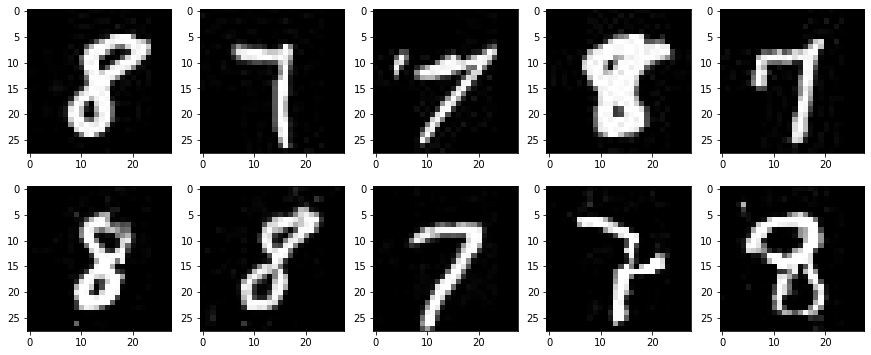

In [30]:
# 생성 화상과 훈련 화상 시각화
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# 입력 난수 생성
batch_size = 8
z_dim = 20
fixed_z = torch.randn(batch_size, z_dim)

G_update.eval()
fake_images = G_update(fixed_z.to(device))

# 훈련 데이터
batch_iterator = iter(train_dataloader)  # 반복자로 변환
images = next(batch_iterator) # 첫번째 요소를 꺼낸다

# 출력
fig = plt.figure(figsize=(15, 6))

for i in range(0, 5) :
    # 상단에 훈련데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i][0].cpu().detach().numpy(), 'gray')
    
    # 하단에 생성 데이터 표시
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(fake_images[i][0].cpu().detach().numpy(), 'gray')

---

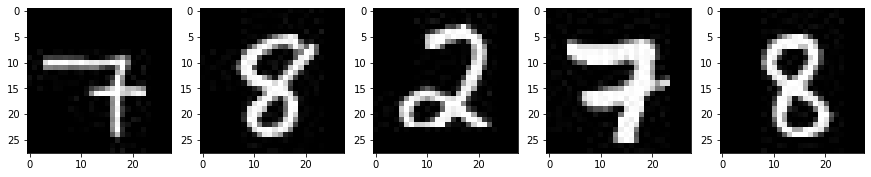

In [49]:
# dataloader 생성
def make_test_datapath_list():

    train_img_list = list() 

    for img_idx in range(5):
        img_path = "./pytorch_advanced/gan_anomaly_detection/data/test_28size/img_7_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./pytorch_advanced/gan_anomaly_detection/data/test_28size/img_8_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

        img_path = "./pytorch_advanced/gan_anomaly_detection/data/test_28size/img_2_" + str(img_idx)+'.jpg'
        train_img_list.append(img_path)

    return train_img_list


test_img_list = make_test_datapath_list()

mean = (0.5,)
std = (0.5,)
test_dataset = GAN_Img_Dataset(
    file_list=test_img_list, transform=ImageTransform(mean, std))

batch_size = 5

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)


batch_iterator = iter(test_dataloader)  
imges = next(batch_iterator)  

fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach
            ().numpy(), 'gray')


In [53]:
def Anomaly_score(x, fake_img, z_out_real, D, Lambda=0.1) :
    
    # 테스트 화상 x와 생성 화상 fake_img의 픽셀 수준 차이의 절댓값을 계산하여
    # 미니 배치마다 합을 구한다
    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)
    
    # 테스트 화상 x와 생성 화상 fake_img를 식별기 D에 입력하여 특징량 맵을 꺼냄
    _, x_feature = D(x, z_out_real)
    _, G_feature = D(fake_img, z_out_real)
    
    # 테스트 화상 x와 생성 화상 fake_img의 특징량 차이의 절댓값을 계산하여
    # 미니 배치마다 합을 구함
    discrimination_loss = torch.abs(x_feature - G_feature)
    discrimination_loss = discrimination_loss.view(discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)
    
    # 미니 배치마다 두 종류 손실을 더함
    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    
    # 모든 미니 배치의 손실을 구함
    total_loss = torch.sum(loss_each)
    
    return total_loss, loss_each, residual_loss

total loss： [182. 164. 289. 231. 120.]


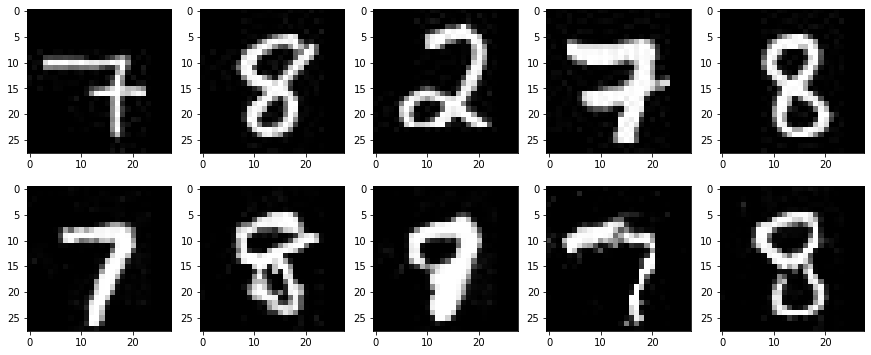

In [54]:
# 이상 탐지 화상
x = imges[0:5]
x = x.to(device)

# 지도 데이터의 화상을 인코드하여 z로 한 후 G에서 생성
E_update.eval()
G_update.eval()
z_out_real = E_update(imges.to(device))
imges_reconstract = G_update(z_out_real)

# 손실을 구함
loss, loss_each, residual_loss_each = Anomaly_score(
    x, imges_reconstract, z_out_real, D_update, Lambda=0.1)

# 손실 계산. 총 손실
loss_each = loss_each.cpu().detach().numpy()
print("total loss：", np.round(loss_each, 0))

# 화상의 시각화
fig = plt.figure(figsize=(15, 6))
for i in range(0, 5):
    # 상단에 훈련데이터 표시
    plt.subplot(2, 5, i+1)
    plt.imshow(imges[i][0].cpu().detach().numpy(), 'gray')

    # 하단에 생성 데이터 표시
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(imges_reconstract[i][0].cpu().detach().numpy(), 'gray')
